In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import robust_loss_pytorch.general

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(-2, 3, 100)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

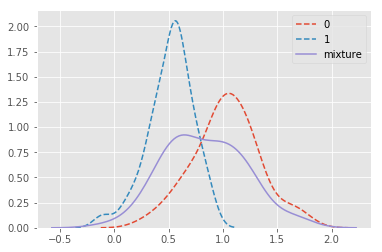

In [35]:
# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 100
scale_true = 0.7
shift_true = 0.15
scale2_true = 1
scale1_true = 1
p = 0.4 # rate to be a member of one group
U = np.random.binomial(1, p, n)

# generate two clusters
X = np.zeros(n)
X[U==1] = np.random.normal(0.5,0.3,sum(U==1))
X[U==0] = np.random.normal(1,0.3,n-sum(U==1))
x = (X-X.mean())/X.std() # standardize

y = scale_true * x + shift_true
y[U==1] = scale2_true * x[U==1] + x[U==1]+ 2*shift_true
y += np.random.normal(scale=0.1, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)
U = torch.Tensor(U)
sns.distplot(X[U==0], hist=False,  kde_kws={'linestyle':'--'}, label='0')
sns.distplot(X[U==1], hist=False, kde_kws={'linestyle':'--'}, label='1')
sns.distplot(X, hist=False, label='mixture')
plt.legend()

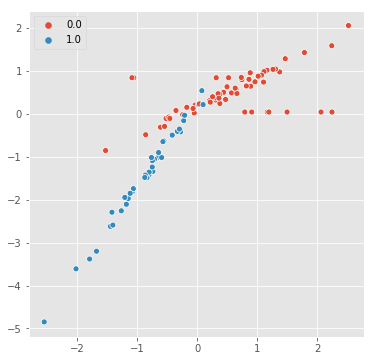

In [36]:
plt.figure(0, figsize=(6,6))
sns.scatterplot(x, y, hue=U)

## Linear regression with regular MSE

0   : loss=42.313522
100 : loss=10.688922
200 : loss=10.536782
300 : loss=10.536777
400 : loss=10.536778
500 : loss=10.536778
600 : loss=10.536779
700 : loss=10.536779
800 : loss=10.536779
900 : loss=10.536779
1000: loss=10.536779
1100: loss=10.536779
1200: loss=10.536779
1300: loss=10.536779
1400: loss=10.536779
1500: loss=10.536779
1600: loss=10.536779
1700: loss=10.536779
1800: loss=10.536778
1900: loss=10.536778


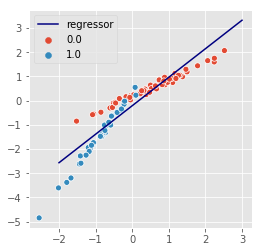

In [31]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)
plt.savefig("exp2_lr1d.png")

0   : loss=50.264671
100 : loss=5.790782
200 : loss=5.046701
300 : loss=5.046519
400 : loss=5.046519
500 : loss=5.046519
600 : loss=5.046519
700 : loss=5.046519
800 : loss=5.046519
900 : loss=5.046519
1000: loss=5.046519
1100: loss=5.046519
1200: loss=5.046519
1300: loss=5.046519
1400: loss=5.046519
1500: loss=5.046519
1600: loss=5.046519
1700: loss=5.046519
1800: loss=5.046519
1900: loss=5.046519


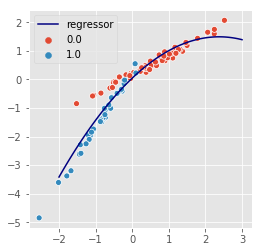

In [32]:
# Fit a linear regression with 2D base expansion using mean squared error.
regression = Poly2RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)
plt.savefig("exp2_lr2d.png")

## Linear regression with Adaptive Roust loss

0   : loss=2.300100  alpha=0.995005  scale=1.006333
100 : loss=1.529449  alpha=1.263123  scale=0.907500
200 : loss=0.627571  alpha=1.535639  scale=0.354147
300 : loss=0.626278  alpha=1.462184  scale=0.343159
400 : loss=0.625164  alpha=1.378647  scale=0.331733
500 : loss=0.624352  alpha=1.296883  scale=0.320914
600 : loss=0.623902  alpha=1.229487  scale=0.312251
700 : loss=0.623715  alpha=1.182605  scale=0.306329
800 : loss=0.623655  alpha=1.154503  scale=0.302816
900 : loss=0.623640  alpha=1.139660  scale=0.300970
1000: loss=0.623637  alpha=1.132707  scale=0.300100
1100: loss=0.623636  alpha=1.130065  scale=0.299762
1200: loss=0.623637  alpha=1.130103  scale=0.299768
1300: loss=0.623637  alpha=1.130107  scale=0.299769
1400: loss=0.623637  alpha=1.130107  scale=0.299769
1500: loss=0.623637  alpha=1.130107  scale=0.299769
1600: loss=0.623637  alpha=1.130107  scale=0.299769
1700: loss=0.623637  alpha=1.130107  scale=0.299769
1800: loss=0.623637  alpha=1.130107  scale=0.299769
1900: loss=0

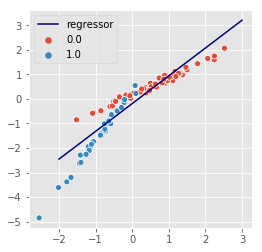

In [33]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)
plt.savefig("exp2_ada1d.png")

0   : loss=1.775140  alpha=1.004995  scale=0.993690
100 : loss=0.499003  alpha=1.507890  scale=0.404082
200 : loss=0.197343  alpha=1.438630  scale=0.226183
300 : loss=0.140851  alpha=0.957448  scale=0.175374
400 : loss=0.108727  alpha=0.595245  scale=0.139654
500 : loss=0.102040  alpha=0.449012  scale=0.125931
600 : loss=0.101165  alpha=0.399024  scale=0.121433
700 : loss=0.101074  alpha=0.382820  scale=0.120004
800 : loss=0.101066  alpha=0.378033  scale=0.119587
900 : loss=0.101066  alpha=0.376784  scale=0.119478
1000: loss=0.101066  alpha=0.376508  scale=0.119452
1100: loss=0.101066  alpha=0.376398  scale=0.119445
1200: loss=0.101066  alpha=0.376225  scale=0.119432
1300: loss=0.101066  alpha=0.376131  scale=0.119424
1400: loss=0.101066  alpha=0.376098  scale=0.119421
1500: loss=0.101066  alpha=0.376109  scale=0.119422
1600: loss=0.101066  alpha=0.376098  scale=0.119421
1700: loss=0.101066  alpha=0.376109  scale=0.119422
1800: loss=0.101066  alpha=0.376095  scale=0.119421
1900: loss=0

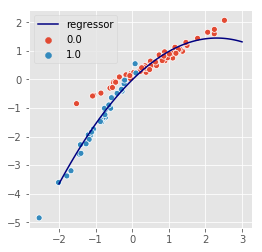

In [34]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)
plt.savefig("exp2_ada2d.png")

## Linear regression with Adaptive Roust loss (Model knows group assignment)

0   : loss=1.757735  alpha=1.004995  scale=0.993690
100 : loss=0.494500  alpha=1.485066  scale=0.402027
200 : loss=0.365778  alpha=1.533563  scale=0.272845
300 : loss=0.355340  alpha=1.335200  scale=0.250401
400 : loss=0.337155  alpha=1.021468  scale=0.216551
500 : loss=0.295193  alpha=0.581638  scale=0.165782
600 : loss=0.243688  alpha=0.257860  scale=0.114830
700 : loss=0.228958  alpha=0.149692  scale=0.095502
800 : loss=0.225775  alpha=0.110983  scale=0.088947
900 : loss=0.224918  alpha=0.093516  scale=0.086173
1000: loss=0.224891  alpha=0.084307  scale=0.084771
1100: loss=0.224546  alpha=0.079039  scale=0.083985
1200: loss=0.224511  alpha=0.075890  scale=0.083524
1300: loss=0.224498  alpha=0.073993  scale=0.083247
1400: loss=0.224494  alpha=0.072854  scale=0.083082
1500: loss=0.224512  alpha=0.072175  scale=0.082994
1600: loss=0.224492  alpha=0.071793  scale=0.082930
1700: loss=0.224492  alpha=0.071553  scale=0.082896
1800: loss=0.224493  alpha=0.071427  scale=0.082880
1900: loss=0

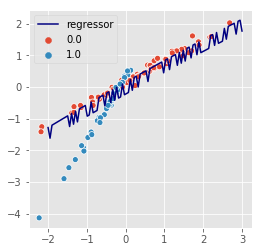

In [28]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel_with_class() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x, U) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U, U)